Welcome to the hands-on lab for **Deploying to Kubernetes / OpenShift**. You are now at the deploy step, which is the last step in your CD pipeline. For this step, you will use the OpenShift client to deploy your Docker image to an OpenShift cluster.

> Note: OpenShift is based on Kubernetes. Anything you can do with Kubernetes, you can do that and more with OpenShift. This lab uses the commands `kubectl` and `oc` interchangeably because `oc` is a proper superset of `kubectl`.

# Learning Objectives

After completing this lab, you will be able to:
* Determine if the openshift-client ClusterTask is available on your cluster
* Describe the parameters required to use the openshift-client ClusterTask
* Use the openshift-client ClusterTask in a Tekton pipeline to deploy your Docker image to Kubernetes

# Set Up the Lab Environment

## Clone the Code Repo

Now, get the code that you need to test. 

To do this, use the `git clone` command to clone the Git repository:
```
git clone https://github.com/ibm-developer-skills-network/wtecc-CICD_PracticeCode.git
```

Your output should look similar to the image below:

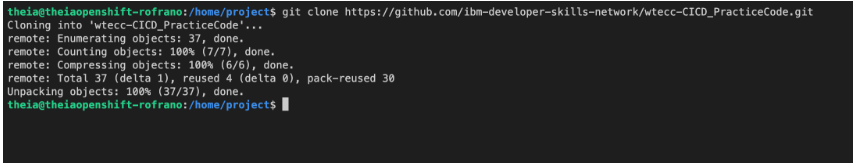

## Change to the Labs Directory

Once you have cloned the repository, change to the labs directory.
```
cd wtecc-CICD_PracticeCode/labs/06_deploy_to_kubernetes/
```

You are now ready to start the lab.

# Prerequisites

If you did not compete the previous labs, you will need to run the following commands to catch up and prepare your environment for this lab. If you have completed the previous labs, you may skip this step, although repeating it will not harm anything because Kubernetes is declarative and idempotent. It will always put the system in the same state given the same commands.

Issue the following commands from the `/home/project/wtecc-CICD_PracticeCode/labs/06_deploy_to_kubernetes/` folder to install everything from the previous labs.
```
cd /home/project/wtecc-CICD_PracticeCode/labs/06_deploy_to_kubernetes/
tkn hub install task git-clone
```

**Note:** If the above command returns an error for the git-clone task due to Tekton Version mismatch, please run the below command to fix this.
```
kubectl apply -f https://raw.githubusercontent.com/tektoncd/catalog/main/task/git-clone/0.9/git-clone.yaml
```
```
tkn hub install task flake8
kubectl apply -f tasks.yaml
kubectl apply -f pvc.yaml
```

**Check that you have all of the previous tasks installed:**
```
tkn task ls
```

**You should see:**

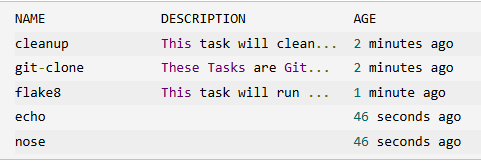

You are now ready to continue with this lab.

# Step 1: Check for the openshift-client ClusterTask

Your pipeline currently has a placeholder for a `deploy` step that uses the `echo` task. Now it is time to replace it with a real deployment.

Knowing that you want to deploy to OpenShift, you search **Tekton Hub** for **“openshift”** and you see there is a task called `openshift-client` that will execute OpenShift commands on your cluster. You decide to use the `openshift-client` task in your pipeline to deploy your image.

Instead of installing it yourself, you first check the **ClusterTasks** in your cluster to see if it already exists. Luckily, the OpenShift environment you are using already has `openshift-client` installed as a **ClusterTask**. A `ClusterTask` is installed cluster-wide by an administrator and anyone can use it in their pipelines without having to install it themselves.

Check that the openshift-client task is installed as a `ClusterTask` using the **Tekton CLI**.
```
tkn clustertask ls
```

You should see the `openshift-client` task in the list with all the other available **ClusterTasks**.

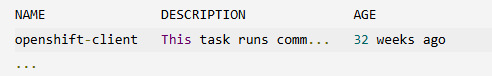

If you see it, you are ready to proceed.

# Step 2: Reference the openshift-client task

First you need to update the `pipeline.yaml` file to use the new `openshift-client` task.

Open `pipeline.yaml` in the editor and scroll down to the `deploy` pipeline task. To open the editor, click the button below.

You must now reference the new `openshift-client` **ClusterTask** that you want to use in the `deploy` pipeline task.

In the previous steps, you simply changed the name of the reference to the task, but since the `openshift-client` task is installed as a `ClusterTask`, you need to add the statement `kind: ClusterTask` under the name so that Tekton knows to look for a `ClusterTask` and not a **regular Task**.

## Your Task

Change the `taskRef` from `echo` to `openshift-client` and add a line below it with `kind: ClusterTask` to indicate that this is a `ClusterTask`.

## Solution

```
      taskRef:
        name: openshift-client
        kind: ClusterTask
```

# Step 3: Update the Task Parameters

The documentation for the `openshift-client` task details that there is a parameter named `SCRIPT1 that you can use to run `oc` commands. Any command you can use with `kubectl` can also be used with `oc`. This is what you will use to deploy your image.

The command to deploy an image on OpenShift is:
```
oc create deployment {name} --image={image-name}
```

Since you might want to reuse this pipeline to deploy different applications, you should make the deployment name a parameter that can be passed in when the pipeline runs. You already have the image name as a parameter from the build task that you can use.

## Your Task

Change the `message` parameter to `SCRIPT` and specify the value of `"oc create deploy $(params.app-name) --image=$(params.build-image)"` in quotes.

## Solution

```
      params:
      - name: SCRIPT
        value: "oc create deploy $(params.app-name) --image=$(params.build-image)"
```

# Step 4: Update the Pipeline Parameters

Now that you are passing in the `app-name` parameter to the `deploy` task, you need to go back to the top of the `pipeline.yaml` file and add the parameter there so that it can be passed into the pipeline when it is run.

## Your Task

Add a parameter named `app-name` to the existing list of parameters at the top of the pipeline under `spec.params`.

## Solution

```
spec:
  params:
    - name: app-name
```

# Step 5: Check Your work

## Code Check

If you changed everything correctly, the full `deploy` task in the pipeline should look like this:
```
    - name: deploy
      taskRef:
        name: openshift-client
        kind: ClusterTask
      params:
      - name: SCRIPT
        value: "oc create deploy $(params.app-name) --image=$(params.build-image)"
      runAfter:
        - build
```

Also, the full parameter list for your pipeline should look like this:
```
spec:
  params:
    - name: app-name
    - name: build-image
    - name: repo-url
    - name: branch
      default: master
```

Save your changes before you continue.

## Terminal Folder Check

Before you proceed with running commands in the terminal, make sure that you are in the `/home/project/wtecc-CICD_PracticeCode/labs/06_deploy_to_kubernetes/` folder.

Go to the terminal and use the `pwd` command just to be sure.
```
pwd
```

You should see: `/home/project/wtecc-CICD_PracticeCode/labs/06_deploy_to_kubernetes/`. If you do not, you should `cd` into that folder now:
```
cd /home/project/wtecc-CICD_PracticeCode/labs/06_deploy_to_kubernetes/
```

You are now ready to run the terminal commands in the next step.

# Step 6: Apply Changes and Run the Pipeline

## Apply the Pipeline

Apply the same changes you just made to `pipeline.yaml` to your cluster:
```
kubectl apply -f pipeline.yaml
```

## Start the Pipeline

When you start the pipeline, you now need to pass in the `app-name` parameter, which is the name of the application to deploy.

Your application is called `hitcounter` so this is the name that you will pass in, along with all the other parameters from the previous steps.

Now, start the pipeline to see your new deploy task run. Use the Tekton CLI `pipeline start` command to run the pipeline, passing in the parameters `repo-url`, `branch`, `app-name`, and `build-image` using the `-p` option. Specify the workspace `pipeline-workspace` and persistent volume claim `pipelinerun-pvc` using the `-w` option:
```
tkn pipeline start cd-pipeline \
    -p repo-url="https://github.com/ibm-developer-skills-network/wtecc-CICD_PracticeCode.git" \
    -p branch=main \
    -p app-name=hitcounter \
    -p build-image=image-registry.openshift-image-registry.svc:5000/$SN_ICR_NAMESPACE/tekton-lab:latest \
    -w name=pipeline-workspace,claimName=pipelinerun-pvc \
    --showlog
```

You should see `Waiting for logs to be available...` while the pipeline runs. The logs will be shown on the screen. Wait until the pipeline run completes successfully.

## Check the Run Status

**You can see the pipeline run status by listing the pipeline runs with:**
```
tkn pipelinerun ls
```

**You should see:**

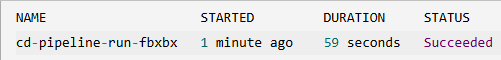

**You can check the logs of the last run with:** `tkn pipelinerun logs --last`

**If it is successful, the last line you should see in the logs is:** `[deploy : oc] deployment.apps/hitcounter created`

If it says anything but created something has gone wrong.

# Step 7: Check the Deployment

Now, check to see if the deployment is running. Use the `kubectl` command to check that your deployment is in a running state.
```
kubectl get all -l app=hitcounter
```

**You should see:**

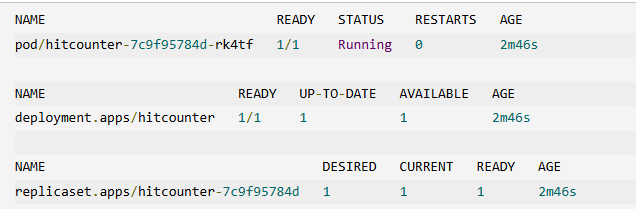

If your **pod** is running, your application has been successfully deployed.

# Conclusion

Congratulations! You have just added the ability to deploy a Docker image to an OpenShift / Kubernetes cluster.

In this lab, you learned how to use the `openshift-client` **ClusterTask** from the **Tekton catalog**. You learned how to modify your pipeline to reference the task as a `ClusterTask` and configure its parameters. You also learned how to pass additional parameters to a pipeline to specify the application name, and how to run the pipeline to deploy an image to OpenShift.